# 필요한 라이브러리 import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow as tf
warnings.filterwarnings(action='ignore')

# 데이터로드

In [3]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']

# 공격수 EDA

In [4]:
# 데이터 분석에 필요한 변수만 추출

num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

## 이상치 확인

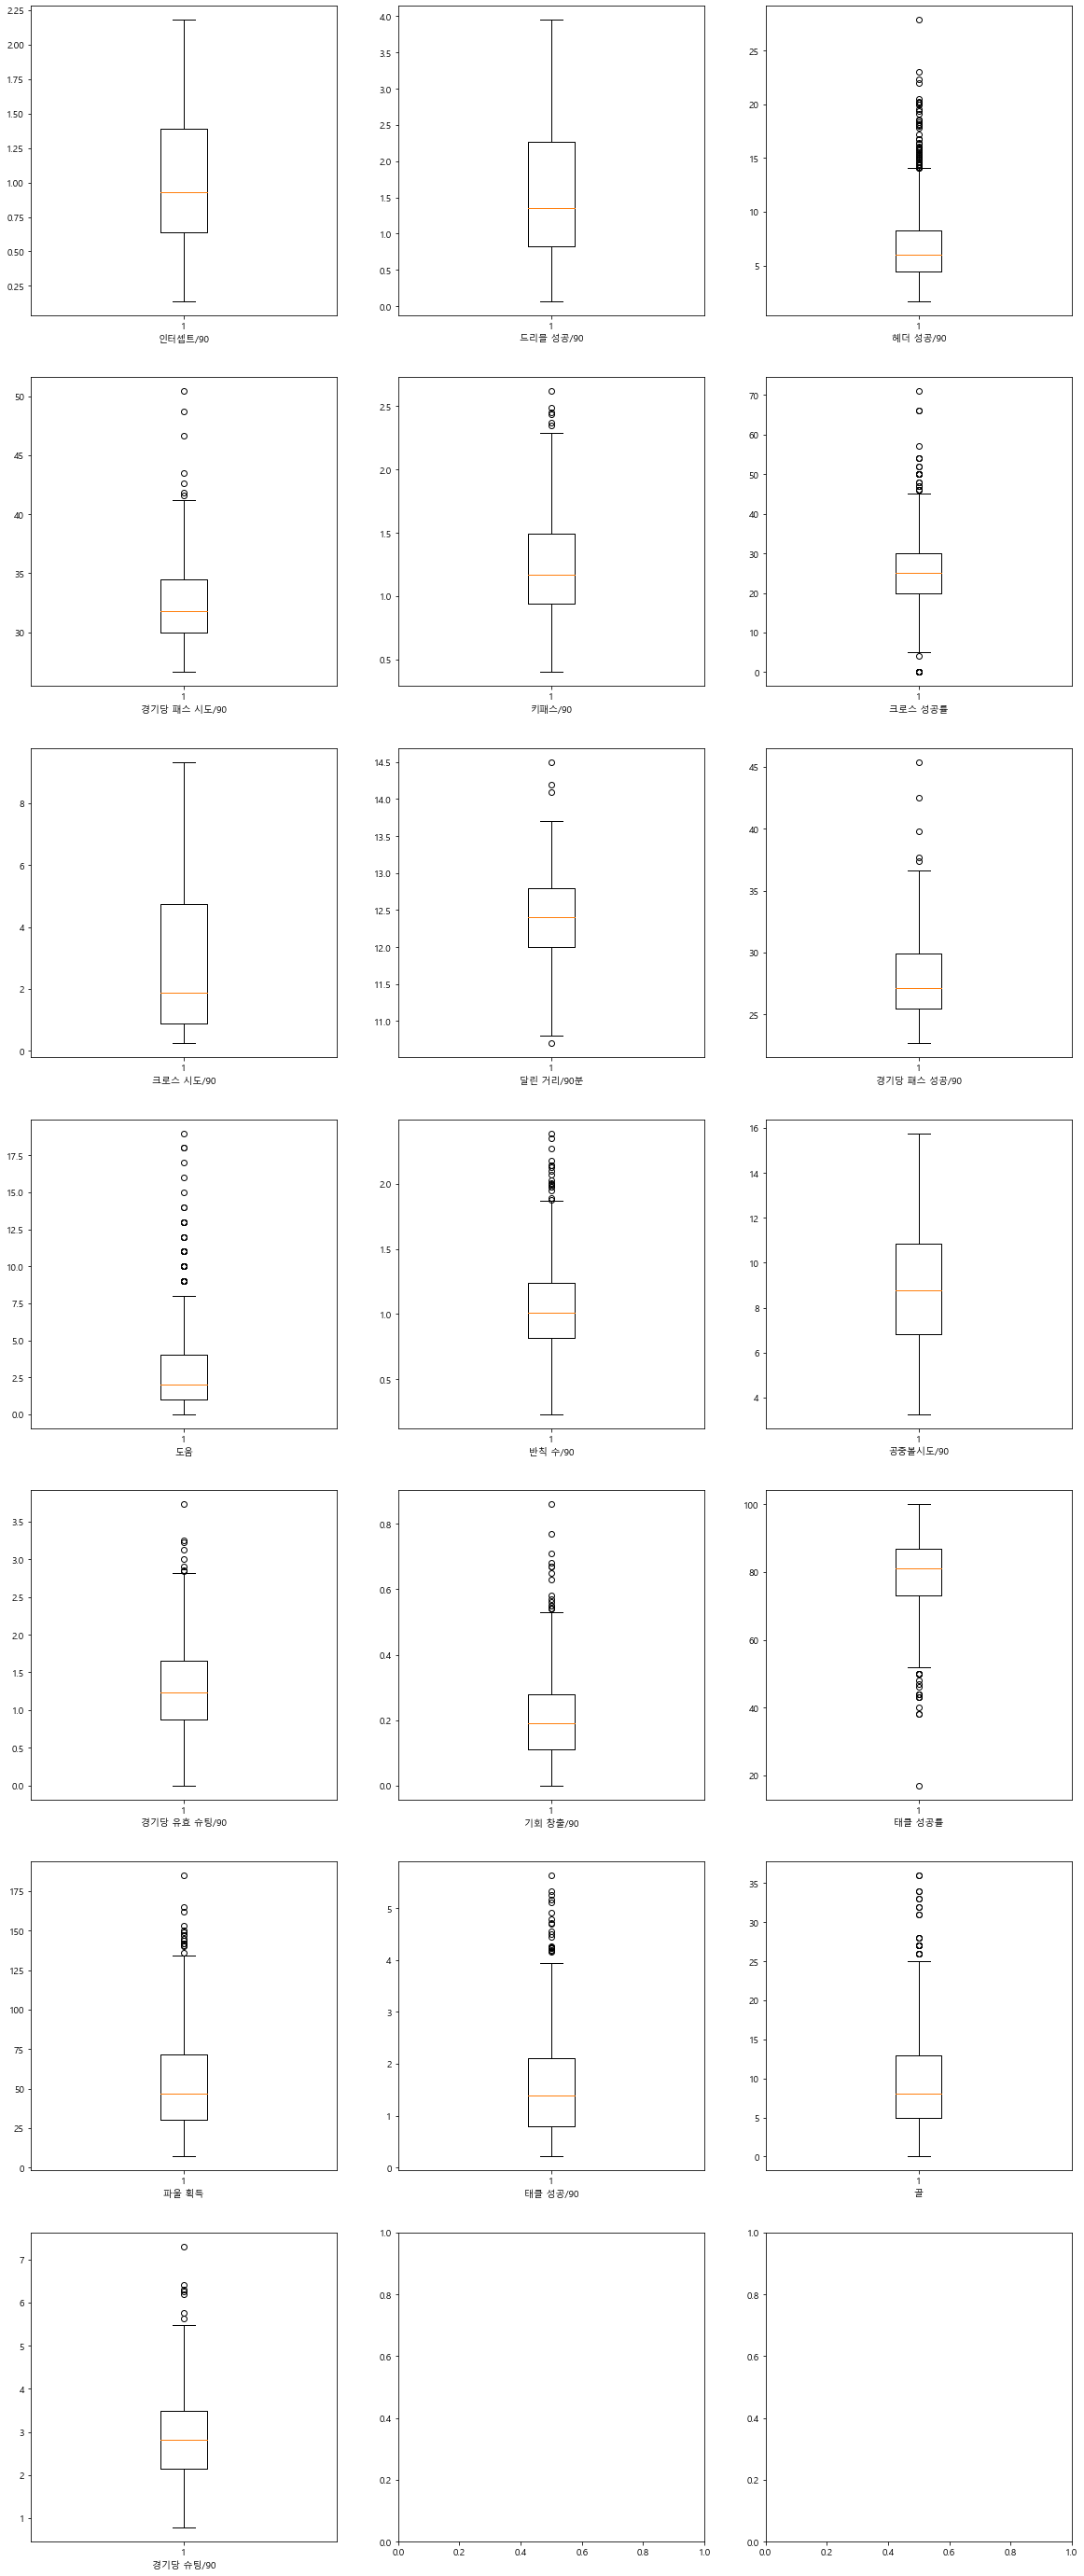

In [5]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature])
    
plt.show()

In [6]:
# 데이터 당 이상치의 비율을 구하기
# 데이터는 990개인데 이상치가 그다지 많지 않다.
# 그래서 이상치의 비율이 5%가 넘는 변수만 tranformer를 적용한다.

out_ratio = defaultdict(float)

order_feature = ['골','도움']

for feature in set(features)-set(order_feature):
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = (len(data[data>high_bound]) + len(data[data>=high_bound])) / len(data)

print(sorted(out_ratio.items(),key=lambda x : x[1],reverse=True))    
    
outlier_features = [k for k,v in out_ratio.items() if v > 0.05]
nonoutlier_features = list((set(features) - set(outlier_features)) -set(order_feature))

[('헤더 성공/90', 0.16363636363636364), ('태클 성공/90', 0.08282828282828283), ('반칙 수/90', 0.06464646464646465), ('기회 창출/90', 0.06060606060606061), ('크로스 성공률', 0.05858585858585859), ('파울 획득', 0.05656565656565657), ('키패스/90', 0.03838383838383838), ('경기당 유효 슈팅/90', 0.03434343434343434), ('경기당 패스 시도/90', 0.03434343434343434), ('경기당 슈팅/90', 0.022222222222222223), ('경기당 패스 성공/90', 0.014141414141414142), ('크로스 시도/90', 0.012121212121212121), ('달린 거리/90분', 0.006060606060606061), ('드리블 성공/90', 0.00202020202020202), ('인터셉트/90', 0.0), ('태클 성공률', 0.0), ('공중볼시도/90', 0.0)]


## 선형성 검정

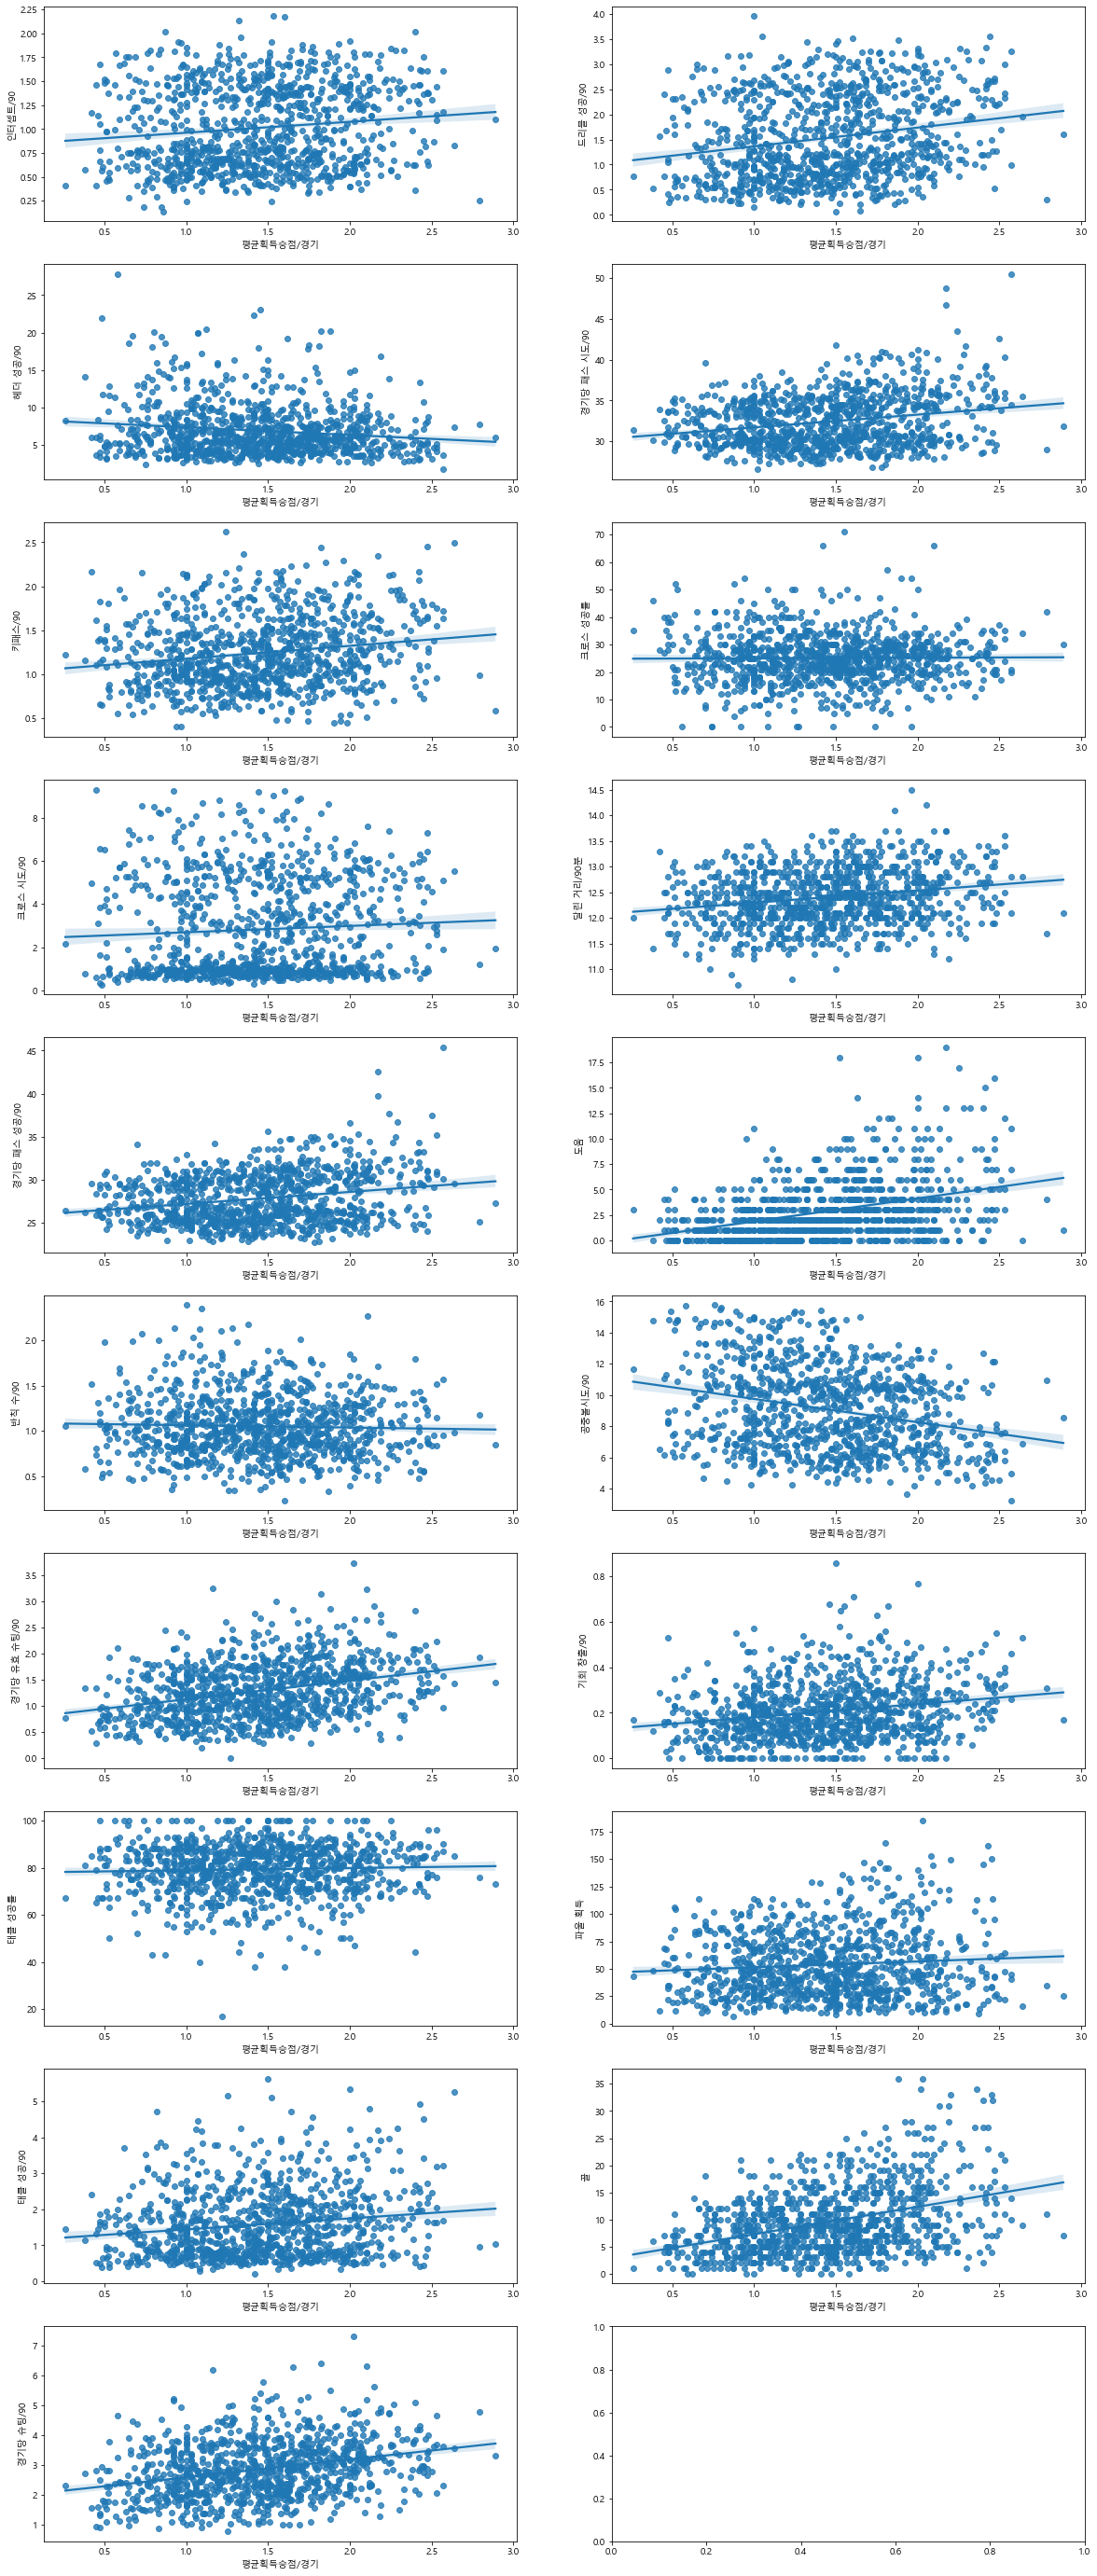

In [7]:
# scatter plot을 이용해서 선형성 검정
# 대부분의 피쳐가 선형성이 없어 보인다.

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [8]:
# target value와의 correlation을 가지고 선형성 확인

corr = [np.corrcoef(x ,y=forward_df.loc[:,target].T.values)[0][1] for x in forward_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('크로스 성공률', 0.01034149433563985),
 ('반칙 수/90', -0.03516430428187815),
 ('헤더 성공/90', -0.14336317747602786),
 ('공중볼시도/90', -0.2635664616800462)]

## 정규성 검정

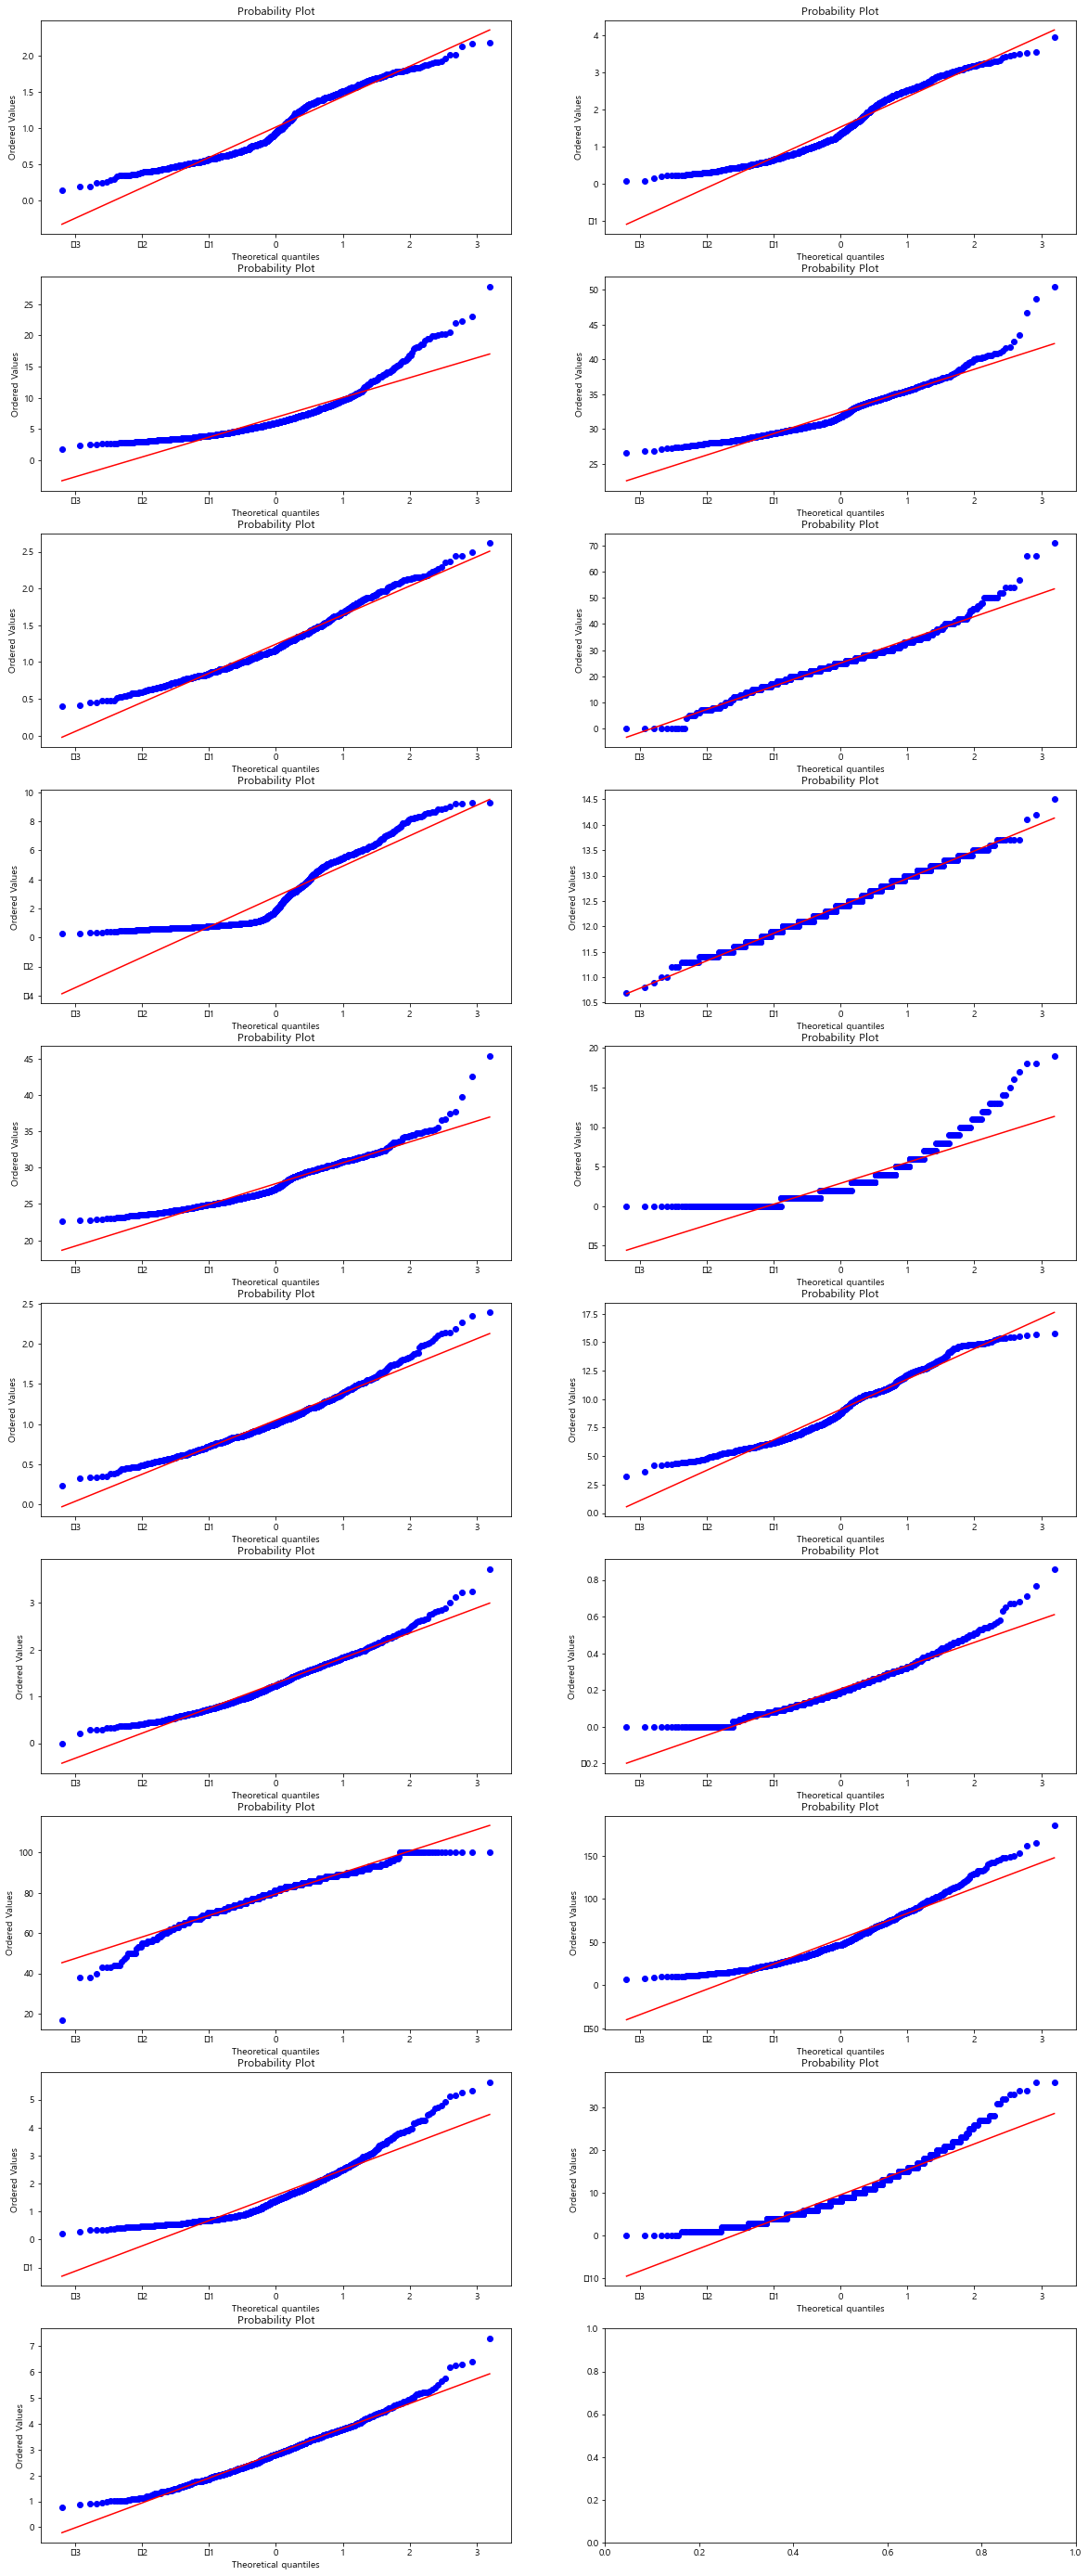

In [9]:
# QQ 플롯을 이용해서 정규성 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    stats.probplot(forward_df.loc[:,feature],dist='norm',plot=ax)
    
plt.show()

In [10]:
# 모든 변수가 정규성을 만족하지 않는다.

shapiro_dict = {}

for feature in features:
    shapiro_dict[feature] = stats.shapiro(forward_df.loc[:,feature])
      
for k,v in shapiro_dict.items():
    if v[1] > 0.05:
        print(f'{k} 은/는 정규성을 만족한다. {v[1]} \n',)
        
    else:
        print(f'{k} 은/는 정규성을 만족하지 않는다.  {v[1]} \n')

인터셉트/90 은/는 정규성을 만족하지 않는다.  3.53519002626841e-18 

드리블 성공/90 은/는 정규성을 만족하지 않는다.  6.292405105902122e-18 

헤더 성공/90 은/는 정규성을 만족하지 않는다.  1.4181624265947407e-29 

경기당 패스 시도/90 은/는 정규성을 만족하지 않는다.  7.358035729467315e-19 

키패스/90 은/는 정규성을 만족하지 않는다.  1.5237267827691858e-12 

크로스 성공률 은/는 정규성을 만족하지 않는다.  2.693583854226911e-12 

크로스 시도/90 은/는 정규성을 만족하지 않는다.  2.9994252397954525e-28 

달린 거리/90분 은/는 정규성을 만족하지 않는다.  0.0004882311914116144 

경기당 패스 성공/90 은/는 정규성을 만족하지 않는다.  2.412282004970018e-18 

도움 은/는 정규성을 만족하지 않는다.  5.289200778417567e-31 

반칙 수/90 은/는 정규성을 만족하지 않는다.  5.135736020484005e-12 

공중볼시도/90 은/는 정규성을 만족하지 않는다.  1.5354534863617347e-13 

경기당 유효 슈팅/90 은/는 정규성을 만족하지 않는다.  4.7671561143047825e-11 

기회 창출/90 은/는 정규성을 만족하지 않는다.  9.418115665384223e-17 

태클 성공률 은/는 정규성을 만족하지 않는다.  5.166333889693045e-15 

파울 획득 은/는 정규성을 만족하지 않는다.  1.977547540519971e-19 

태클 성공/90 은/는 정규성을 만족하지 않는다.  2.6788884093050553e-24 

골 은/는 정규성을 만족하지 않는다.  9.412561093610319e-22 

경기당 슈팅/90 은/는 정규성을 만족하지 않는다.  1.4326889008486887e

## 등분산성 검정

In [11]:
# 변수간 등분산성을 만족하지 않는다.
stats.levene(*tuple([ tuple(x) for x in forward_df.loc[:,features].values]))

LeveneResult(statistic=0.1294975900958157, pvalue=0.9999999999999999)

## 다중 공선성 확인

In [12]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(forward_df.loc[:,features].values,i) for i in range(forward_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = forward_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,3.788092,도움
1,4.842201,기회 창출/90
2,9.795654,크로스 성공률
3,9.811395,크로스 시도/90
4,12.446589,반칙 수/90
5,12.987407,골
6,13.549914,태클 성공/90
7,15.434996,파울 획득
8,18.562202,헤더 성공/90
9,21.472031,드리블 성공/90


## 변수 정규화 및 변수 선택

### 변수 정규화

In [13]:
norm_forward_df = forward_df.copy()

forward_mm = MinMaxScaler().fit(norm_forward_df.loc[:,order_feature])
norm_forward_df.loc[:,order_feature] = forward_mm.transform(norm_forward_df.loc[:,order_feature])

forward_qt = QuantileTransformer(n_quantiles=100,output_distribution='normal').fit(norm_forward_df.loc[:,outlier_features])
norm_forward_df.loc[:,outlier_features] = forward_qt.transform(norm_forward_df.loc[:,outlier_features])

forward_ss = StandardScaler().fit(norm_forward_df.loc[:,nonoutlier_features])
norm_forward_df.loc[:,nonoutlier_features] = forward_ss.transform(norm_forward_df.loc[:,nonoutlier_features])

In [14]:
with open('./models/forward_qt.pickle','wb') as f:
    pickle.dump(forward_qt,f)
    
with open('./models/forward_ss.pickle','wb') as f:
    pickle.dump(forward_ss,f)
    
with open('./models/forward_mm.pickle','wb') as f:
    pickle.dump(forward_mm,f)

In [15]:
outlier_features

['헤더 성공/90', '크로스 성공률', '기회 창출/90', '파울 획득', '태클 성공/90', '반칙 수/90']

In [16]:
nonoutlier_features

['크로스 시도/90',
 '달린 거리/90분',
 '태클 성공률',
 '경기당 유효 슈팅/90',
 '경기당 패스 성공/90',
 '인터셉트/90',
 '드리블 성공/90',
 '경기당 패스 시도/90',
 '경기당 슈팅/90',
 '공중볼시도/90',
 '키패스/90']

### 상관계수와 시각화를 통한 변수 선택

In [17]:
feature_comb = list(combinations(features,2))

In [18]:
'''
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)
'''

'\nfig , axes = plt.subplots(43,4,figsize=(100,860))\n\nfor i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):\n    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)\n'

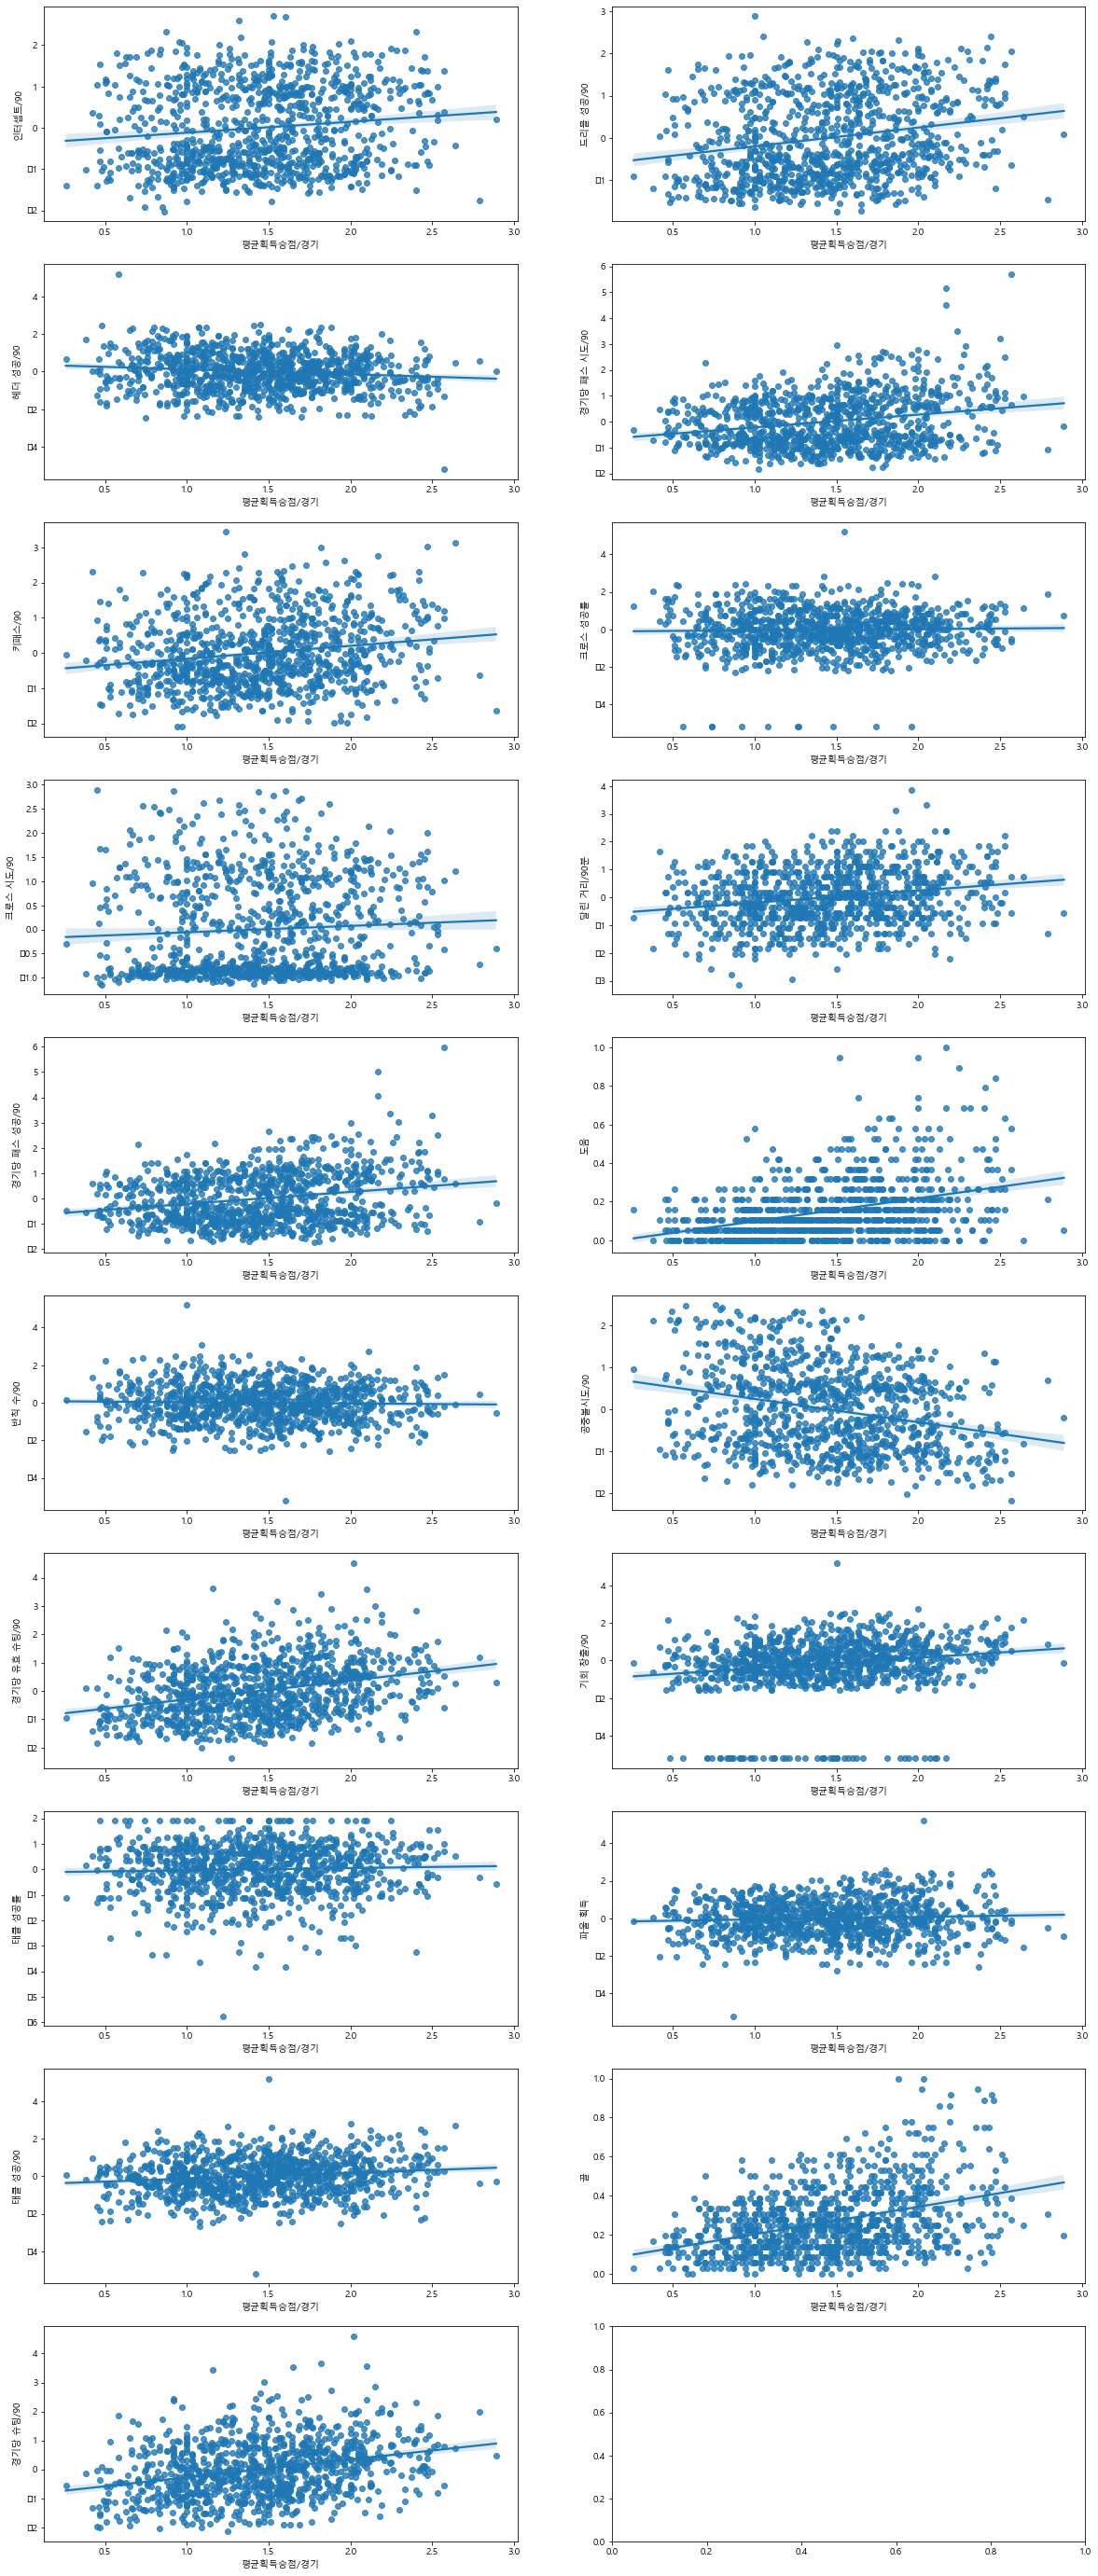

In [19]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_forward_df.loc[:,target],norm_forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [20]:
corr_dict_after_norm = {}

for feature in features:
    corr_dict_after_norm[f'크로스 성공률/{feature}'] = np.corrcoef(forward_df.loc[:,'크로스 성공률'],forward_df.loc[:,feature])[0][1]
    
sorted(corr_dict_after_norm.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('크로스 성공률/크로스 성공률', 1.0),
 ('크로스 성공률/태클 성공률', -0.216947464058169),
 ('크로스 성공률/드리블 성공/90', 0.07330437348732645),
 ('크로스 성공률/기회 창출/90', 0.07218387447456645),
 ('크로스 성공률/키패스/90', 0.044124550659364166),
 ('크로스 성공률/인터셉트/90', 0.038781762935857035),
 ('크로스 성공률/공중볼시도/90', -0.037765269028310976),
 ('크로스 성공률/크로스 시도/90', 0.03445782899988405),
 ('크로스 성공률/경기당 패스 시도/90', 0.032233967680183453),
 ('크로스 성공률/반칙 수/90', 0.03052566347617101),
 ('크로스 성공률/골', -0.02793542274778062),
 ('크로스 성공률/파울 획득', -0.02783878859816604),
 ('크로스 성공률/도움', 0.026392928787799322),
 ('크로스 성공률/달린 거리/90분', 0.020991551439689303),
 ('크로스 성공률/헤더 성공/90', -0.020454154008185815),
 ('크로스 성공률/태클 성공/90', 0.00921073670352573),
 ('크로스 성공률/경기당 슈팅/90', 0.004892357742651992),
 ('크로스 성공률/경기당 유효 슈팅/90', 0.0030456461322250195),
 ('크로스 성공률/경기당 패스 성공/90', -0.0021686868607216215)]

In [21]:
sorted(corr_dict.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('공중볼시도/90', -0.2635664616800462),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('헤더 성공/90', -0.14336317747602786),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('반칙 수/90', -0.03516430428187815),
 ('크로스 성공률', 0.01034149433563985)]

In [22]:
# 상관계수가 높은 변수

# 전진선택법을 위한 변수의 우선순위 순 


good_feature_order = ['골','도움','경기당 유효 슈팅/90','공중볼시도/90','경기당 패스 시도/90',
                      '기회 창출/90','드리블 성공/90','크로스 성공률']

checkpoint_filepath = './tmp/'

forward_mae = []
forward_model = []

for i in range(1,len(good_feature_order)+1):
    
    print(good_feature_order[:i])
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_feature_order[:i]],norm_forward_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(128,activation='swish')(inputs_layer)
    hidden2 = Dense(64,activation='swish')(hidden1)
    hidden3 = Dense(32,activation='swish')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    model.fit(fx_train,fy_train,batch_size=70,epochs=50,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    forward_mae.append(mae)
    forward_model.append(model)

['골']
Epoch 1/50
12/12 [==============================] - 1s 14ms/step - loss: 2.0760 - val_loss: 1.5636
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 1.3112 - val_loss: 0.6458
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.2177
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2905 - val_loss: 0.2011
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2316 - val_loss: 0.1750
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2209 - val_loss: 0.1710
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2153 - val_loss: 0.1686
Epoch 8/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2095 - val_loss: 0.1633
Epoch 9/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2078 - val_loss: 0.1630
Epoch 10/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2056 - val_loss: 0.1643
Epoch 11/50


12/12 [==============================] - 0s 4ms/step - loss: 0.1778 - val_loss: 0.1821
Epoch 34/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1787 - val_loss: 0.1817
Epoch 35/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1820 - val_loss: 0.1828
Epoch 36/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1791 - val_loss: 0.1816
Epoch 37/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1787 - val_loss: 0.1822
Epoch 38/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1781 - val_loss: 0.1825
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1781 - val_loss: 0.1816
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1787 - val_loss: 0.1825
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1783 - val_loss: 0.1816
Epoch 42/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1779 - val_loss: 0.1821
Epoch 43/50
12/12 [===

12/12 [==============================] - 0s 4ms/step - loss: 0.1382 - val_loss: 0.1390
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1367 - val_loss: 0.1378
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1358 - val_loss: 0.1378
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1356 - val_loss: 0.1365
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1353 - val_loss: 0.1366
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1356 - val_loss: 0.1353
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1357 - val_loss: 0.1377
Epoch 22/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1346 - val_loss: 0.1357
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1351 - val_loss: 0.1362
Epoch 24/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1351 - val_loss: 0.1376
Epoch 25/50
12/12 [===

12/12 [==============================] - 0s 4ms/step - loss: 0.1242 - val_loss: 0.1393
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1239 - val_loss: 0.1370
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1233 - val_loss: 0.1370
Epoch 50/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1237 - val_loss: 0.1365
['골', '도움', '경기당 유효 슈팅/90', '공중볼시도/90', '경기당 패스 시도/90', '기회 창출/90']
Epoch 1/50
12/12 [==============================] - 0s 12ms/step - loss: 2.0044 - val_loss: 1.6387
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 1.1847 - val_loss: 0.7430
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.4090 - val_loss: 0.1992
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2349 - val_loss: 0.1555
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1751 - val_loss: 0.1520
Epoch 6/50
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 6ms/step - loss: 0.1278 - val_loss: 0.1017
Epoch 29/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1284 - val_loss: 0.1027
Epoch 30/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1269 - val_loss: 0.1013
Epoch 31/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1269 - val_loss: 0.1052
Epoch 32/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1294 - val_loss: 0.1016
Epoch 33/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1264 - val_loss: 0.1019
Epoch 34/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1266 - val_loss: 0.1016
Epoch 35/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1262 - val_loss: 0.1020
Epoch 36/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1259 - val_loss: 0.1022
Epoch 37/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1255 - val_loss: 0.1019
Epoch 38/50
12/12 [===

In [23]:
forward_mae

[0.33170424056775644,
 0.33295387479994026,
 0.33186079269707797,
 0.29303927879140834,
 0.2933708479548946,
 0.2806348568622512,
 0.2622914979915426,
 0.2996870920634028]

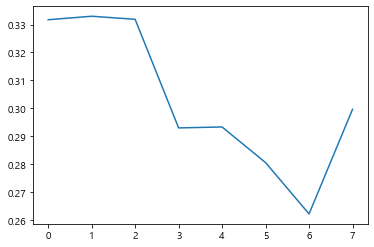

In [24]:
plt.plot(forward_mae)
plt.show()

In [25]:
good_features = good_feature_order[0:np.argmin(np.array(forward_mae))+1]
#good_features.append(good_feature_order[6])
good_features

['골',
 '도움',
 '경기당 유효 슈팅/90',
 '공중볼시도/90',
 '경기당 패스 시도/90',
 '기회 창출/90',
 '드리블 성공/90']

In [35]:
fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_features],norm_forward_df.loc[:,target],test_size=0.2)

In [36]:
inputs_layer = Input(shape=(len(good_features),))
hidden1 = Dense(256,activation='swish')(inputs_layer)
hidden2 = Dense(512,activation='swish')(hidden1)
hidden3 = Dropout(0.1)(hidden2)
hidden4 = Dense(1024,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(2048,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden4)
hidden6 = Dropout(0.1)(hidden5)
hidden7 = Dense(1024,activation='swish')(hidden6)
hidden8 = Dense(512,activation='swish')(hidden7)
hidden9 = Dense(256,activation='swish')(hidden8)
hidden10 = Dense(128,activation='swish')(hidden9)
hidden11 = Dense(4,activation='swish')(hidden10)
output = Dense(1,activation='linear')(hidden11)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.0005)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
model.fit(fx_train,fy_train,batch_size=70,epochs=600,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
print(mae)
model.save('./models/forward_nn.h5')

Epoch 1/600
12/12 [==============================] - 1s 37ms/step - loss: 19.0751 - val_loss: 14.4317
Epoch 2/600
12/12 [==============================] - 0s 11ms/step - loss: 12.4864 - val_loss: 10.0738
Epoch 3/600
12/12 [==============================] - 0s 11ms/step - loss: 8.6024 - val_loss: 6.8046
Epoch 4/600
12/12 [==============================] - 0s 11ms/step - loss: 5.7842 - val_loss: 4.5361
Epoch 5/600
12/12 [==============================] - 0s 11ms/step - loss: 3.8487 - val_loss: 2.9983
Epoch 6/600
12/12 [==============================] - 0s 11ms/step - loss: 2.5565 - val_loss: 1.9888
Epoch 7/600
12/12 [==============================] - 0s 11ms/step - loss: 1.7119 - val_loss: 1.3285
Epoch 8/600
12/12 [==============================] - 0s 11ms/step - loss: 1.1588 - val_loss: 0.9036
Epoch 9/600
12/12 [==============================] - 0s 11ms/step - loss: 0.8070 - val_loss: 0.6266
Epoch 10/600
12/12 [==============================] - 0s 11ms/step - loss: 0.5796 - val_loss: 0.

12/12 [==============================] - 0s 12ms/step - loss: 0.1311 - val_loss: 0.1116
Epoch 163/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1311 - val_loss: 0.1139
Epoch 164/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1337 - val_loss: 0.1145
Epoch 165/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1329 - val_loss: 0.1151
Epoch 166/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1339 - val_loss: 0.1113
Epoch 167/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1353 - val_loss: 0.1111
Epoch 168/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1313 - val_loss: 0.1121
Epoch 169/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1300 - val_loss: 0.1112
Epoch 170/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1298 - val_loss: 0.1150
Epoch 171/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1297 - val_loss: 0

12/12 [==============================] - 0s 12ms/step - loss: 0.1389 - val_loss: 0.1190
Epoch 323/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1398 - val_loss: 0.1148
Epoch 324/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1298 - val_loss: 0.1112
Epoch 325/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1311 - val_loss: 0.1115
Epoch 326/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1295 - val_loss: 0.1097
Epoch 327/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1277 - val_loss: 0.1093
Epoch 328/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1256 - val_loss: 0.1086
Epoch 329/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1254 - val_loss: 0.1134
Epoch 330/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1272 - val_loss: 0.1075
Epoch 331/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1262 - val_loss: 0

12/12 [==============================] - 0s 12ms/step - loss: 0.1260 - val_loss: 0.1109
Epoch 483/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1254 - val_loss: 0.1105
Epoch 484/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1294 - val_loss: 0.1126
Epoch 485/600
12/12 [==============================] - 0s 13ms/step - loss: 0.1243 - val_loss: 0.1112
Epoch 486/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1260 - val_loss: 0.1124
Epoch 487/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1244 - val_loss: 0.1087
Epoch 488/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1254 - val_loss: 0.1099
Epoch 489/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1288 - val_loss: 0.1102
Epoch 490/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1255 - val_loss: 0.1104
Epoch 491/600
12/12 [==============================] - 0s 12ms/step - loss: 0.1230 - val_loss: 0